# Ephemeris generation for given orbit with GRSS

In [1]:
from grss import prop, fit, utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Specify body and get orbit from SBDB
body_id = '65803'
orbit, cov, nongrav_info = fit.get_sbdb_info(body_id)
mass = 0.0
radius = nongrav_info['radius']

In [3]:
# Specify integration window
t0 = orbit['t']
num_days = 50
tf = t0 + num_days

In [4]:
# Specify DE kernel (431 or 441)
de_kernel = 441
de_kernel_path = utils.default_kernel_path
prop_sim = prop.PropSimulation(f"{body_id} ephemeris", t0, de_kernel, de_kernel_path)

In [5]:
# output information at daily(ish) intervals
num_pts = int(num_days+1)
t_eval = np.linspace(t0, tf, num_pts)
# Flag to specify if t_eval is in UTC or TDB
t_eval_utc = True
# Flag to specify whether to output apparent states instead of geometric
eval_apparent_state = True
# Flag to specify whether to use converged light time correction when computing apparent states
converged_lt = True
# Specify the observer coordinates (MPC code or user-defined)
mpc_sites = fit.get_codes_dict()
stn = 'X05' # LSST
stn_info = (399,) + mpc_sites[stn] # (central body SPICE ID, longitude, geocentric latitude, geocentric distance)
observer_info = [stn_info]*len(t_eval)

# Specify the integration parameters
prop_sim.set_integration_parameters(tf, t_eval, t_eval_utc, eval_apparent_state, converged_lt, observer_info)

In [6]:
# GRSS uses MJD times and radian angles for orbit input
e = orbit['e']
q = orbit['q']
tp = orbit['tp']
om = orbit['om']
w = orbit['w']
i = orbit['i']
com_elems = np.array([e, q, tp, om, w, i])

# Nongravitational parameters according to Marsden et al. (1973) model
# A1, A2, A3 + coefficients/exponents for the power laws
ng_params = prop.NongravParameters()
ng_params.a1 = orbit.get('a1', 0.0)
ng_params.a2 = orbit.get('a2', 0.0)
ng_params.a3 = orbit.get('a3', 0.0)
ng_params.alpha = 1.0
ng_params.k = 0.0
ng_params.m = 2.0
ng_params.n = 0.0
ng_params.r0_au = 1.0

# Add the body to the simulation
body = prop.IntegBody(body_id, t0, mass, radius, com_elems, ng_params)
prop_sim.add_integ_body(body)

In [7]:
# integrate the body
prop_sim.integrate()

In [8]:
# get the apparent states, positions, and velocities
states = np.array(prop_sim.xIntegEval)
pos = states[:,:3]
r = np.linalg.norm(pos, axis=1)
vel = states[:,3:6]
v = np.linalg.norm(vel, axis=1)
rdot = np.sum(pos*vel, axis=1)/r

In [9]:
# compute ra (0-360) and dec from states
ra = np.arctan2(pos[:,1], pos[:,0]) % (2*np.pi)
dec = np.arcsin(pos[:,2]/r)
cos_dec = np.cos(dec)
# compute ra and dec rates from states
xy_dist = np.linalg.norm(pos[:,:2], axis=1)
ra_rate = (vel[:,0]*pos[:,1] - vel[:,1]*pos[:,0])/-xy_dist**2
dec_rate = (vel[:,2] - rdot*np.sin(dec))/xy_dist

In [10]:
# put together ra, dec in degrees
obs = np.array([ra, dec]).T*180.0/np.pi
# put together ra_rate, dec_rate in degrees/day
obs_dot = np.array([ra_rate*cos_dec, dec_rate]).T*180.0/np.pi

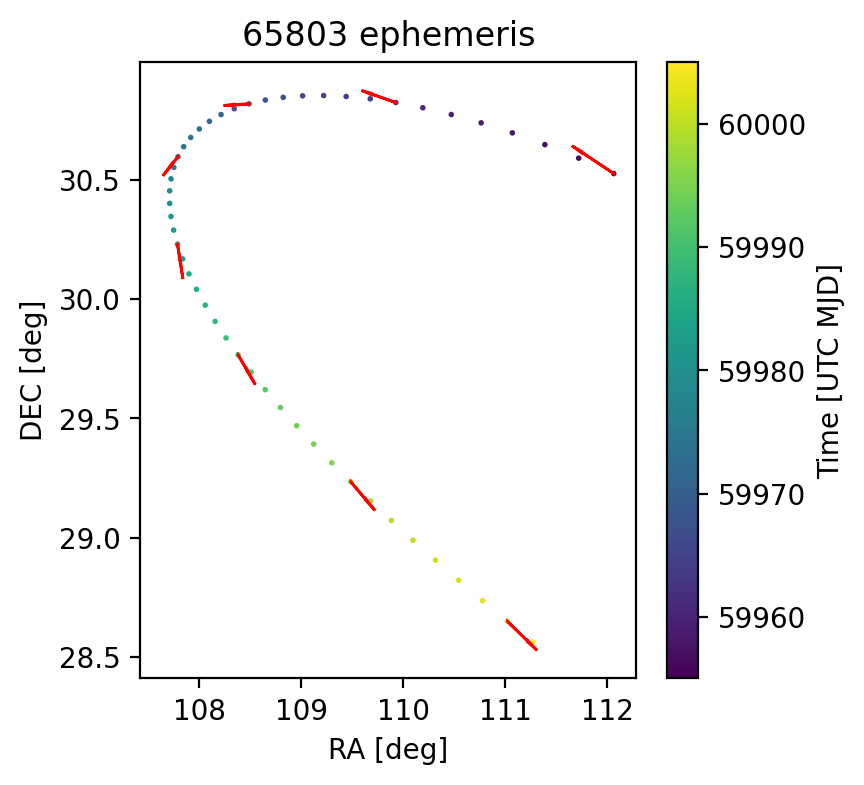

In [11]:
plt.figure(figsize=(4, 4), dpi=200)
plt.scatter(obs[:, 0], obs[:, 1], c = t_eval, cmap='viridis', s=1)
# plot vector field of ra, dec rates
for i in range(0, num_pts, 7):
    plt.arrow(obs[i, 0], obs[i, 1], obs_dot[i, 0], obs_dot[i, 1], head_width=0.1/15, head_length=0.1, fc='r', ec='r')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
timescale = 'UTC' if t_eval_utc else 'TDB'
plt.colorbar(label=f'Time [{timescale} MJD]')
plt.title(f'{body_id} ephemeris')
plt.show()